In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.ensemble import \
    RandomForestRegressor  # Use RandomForestClassifier for classification
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import DataLoader, TensorDataset

In [2]:
df_oni = pd.read_csv("../../datasets/csv/ONI_data.csv")
df_oni = df_oni.rename(columns={"Year": "year"})
df_oni = df_oni.drop(["DJF", "NDJ"], axis=1)
df_oni.head()

,year,JFM,FMA,MAM,AMJ,MJJ,JJA,JAS,ASO,SON,OND
0,1950,-1.3,-1.2,-1.2,-1.1,-0.9,-0.5,-0.4,-0.4,-0.4,-0.6
1,1951,-0.5,-0.2,0.2,0.4,0.6,0.7,0.9,1.0,1.2,1.0
2,1952,0.4,0.3,0.3,0.2,0.0,-0.1,0.0,0.2,0.1,0.0
3,1953,0.6,0.6,0.7,0.8,0.8,0.7,0.7,0.8,0.8,0.8
4,1954,0.5,0.0,-0.4,-0.5,-0.5,-0.6,-0.8,-0.9,-0.8,-0.7


In [3]:
df_oni = df_oni.melt(id_vars=["year"], var_name="season", value_name="ONI")

In [4]:
df_oni.head()

,year,season,ONI
0,1950,JFM,-1.3
1,1951,JFM,-0.5
2,1952,JFM,0.4
3,1953,JFM,0.6
4,1954,JFM,0.5


In [5]:
season_to_month = {
    "JFM": "February",
    "FMA": "March",
    "MAM": "April",
    "AMJ": "May",
    "MJJ": "June",
    "JJA": "July",
    "JAS": "August",
    "ASO": "September",
    "SON": "October",
    "OND": "November"
}

season_to_month_num = {
    "JFM": 2,  # February
    "FMA": 3,  # March
    "MAM": 4,  # April
    "AMJ": 5,  # May
    "MJJ": 6,  # June
    "JJA": 7,  # July
    "JAS": 8,  # August
    "ASO": 9,  # September
    "SON": 10, # October
    "OND": 11  # November
}

In [6]:
# df_oni["month"] = df_oni["season"].map(season_to_month)
df_oni["month"] = df_oni["season"].map(season_to_month_num)
df_oni.head()

,year,season,ONI,month
0,1950,JFM,-1.3,2
1,1951,JFM,-0.5,2
2,1952,JFM,0.4,2
3,1953,JFM,0.6,2
4,1954,JFM,0.5,2


In [7]:
df_enso = pd.read_csv("../../datasets/csv/enso_data.csv")
df_enso = df_enso.rename(columns={"YR": "year", "MON": "month"})
df_enso.head()

,year,month,TOTAL,ClimAdjust,ANOM
0,1950,1,24.56,26.18,-1.62
1,1950,2,25.07,26.39,-1.32
2,1950,3,25.88,26.95,-1.07
3,1950,4,26.29,27.39,-1.11
4,1950,5,26.19,27.56,-1.37


In [8]:
df_features = pd.merge(
    df_enso, df_oni, on=["year", "month"], how="inner"
).dropna()
df_features.head()

,year,month,TOTAL,ClimAdjust,ANOM,season,ONI
0,1950,2,25.07,26.39,-1.32,JFM,-1.3
1,1950,3,25.88,26.95,-1.07,FMA,-1.2
2,1950,4,26.29,27.39,-1.11,MAM,-1.2
3,1950,5,26.19,27.56,-1.37,AMJ,-1.1
4,1950,6,26.47,27.21,-0.74,MJJ,-0.9


In [9]:
print(len(df_features))
print(len(df_oni))
print(len(df_enso))

750
750
901


In [10]:
df_label = pd.read_csv('../../datasets/csv/doy_cherry_peak_bloom_Japan_Tsu.csv')

In [12]:
df = pd.merge(df_label, df_features, on='year', how='inner').dropna()
df.sample(10)

,year,doy_cherry_peak_bloom,month,TOTAL,ClimAdjust,ANOM,season,ONI
152,1968,99,4,27.10,27.40,-0.30,MAM,-0.4
458,1998,90,10,25.26,26.67,-1.41,SON,-1.4
446,1997,94,8,28.74,26.83,1.91,JAS,1.9
38,1956,100,10,25.74,26.03,-0.29,SON,-0.4
337,1986,98,9,27.24,26.59,0.65,ASO,0.7
415,1994,97,7,27.54,27.19,0.35,JJA,0.4
154,1968,99,6,27.87,27.35,0.52,MJJ,0.3
200,1973,103,2,27.95,26.61,1.34,JFM,1.2
597,2012,99,9,27.10,26.72,0.38,ASO,0.4
252,1978,104,4,27.12,27.42,-0.30,MAM,-0.2


In [24]:
# Assign a numerical value to each season category
df['season_encoded'] = df['season'].map(season_to_month_num)

# Create the cyclical features using sine and cosine
# We divide by the total number of categories to map the values to [0, 2π)
num_seasons = len(season_to_month_num) 
df['season_sin'] = np.sin(2 * np.pi * df['season_encoded'] / num_seasons)
df['season_cos'] = np.cos(2 * np.pi * df['season_encoded'] / num_seasons)

In [33]:
# Sort data by year to ensure chronological order
df = df.sort_values("year")

# Define features (X) and target (y)
# Drop the intermediate encoding and the original category
X = df.drop(columns=["season", "season_encoded", "year", "doy_cherry_peak_bloom"])
y = df["doy_cherry_peak_bloom"]  # Target variable

# Define the cut-off point (e.g., last 20% of years for testing)
split_idx = int(len(df) * 0.8)

# Create the train/test split
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

# Print the shapes of the splits
print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (552, 7), Test set: (138, 7)


In [34]:
# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf.fit(X_train, y_train)
doy_pred_training = rf.predict(X_train)

# Make predictions on the test set
doy_pred = rf.predict(X_test)

In [35]:
# Evaluate the model
mse = mean_squared_error(y_test, doy_pred)
r2 = r2_score(y_test, doy_pred)

print("Mean Squared Error:", mse)
print("R2 Score:", r2)

Mean Squared Error: 34.14381692834138
R2 Score: -1.8873661171551213


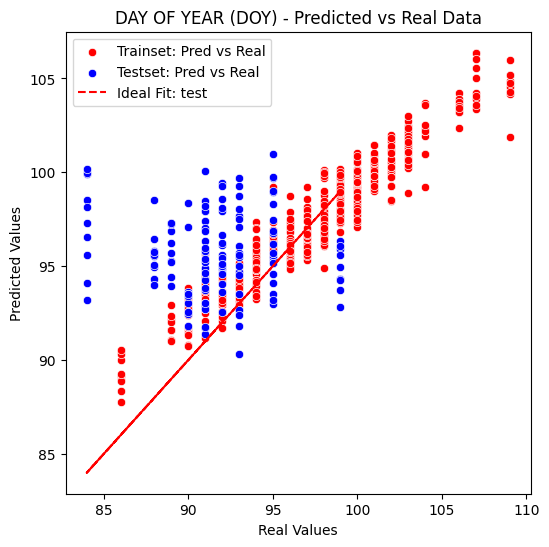

In [36]:
# Example data
real_values = y_test
predicted_values = doy_pred

# Create scatter plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_train, y=doy_pred_training, label="Trainset: Pred vs Real", color="red")

sns.scatterplot(x=real_values, y=predicted_values, label="Testset: Pred vs Real", color="blue")

# Plot y=x line for reference
plt.plot(real_values, real_values, color="red", linestyle="--", label="Ideal Fit: test")

# Labels and title
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("DAY OF YEAR (DOY) - Predicted vs Real Data")
plt.legend()

# Show plot
plt.show()

      Feature  Importance
2  ClimAdjust    0.267960
1       TOTAL    0.250198
3        ANOM    0.212101
4         ONI    0.141852
0       month    0.052005
6  season_cos    0.046424
5  season_sin    0.029461


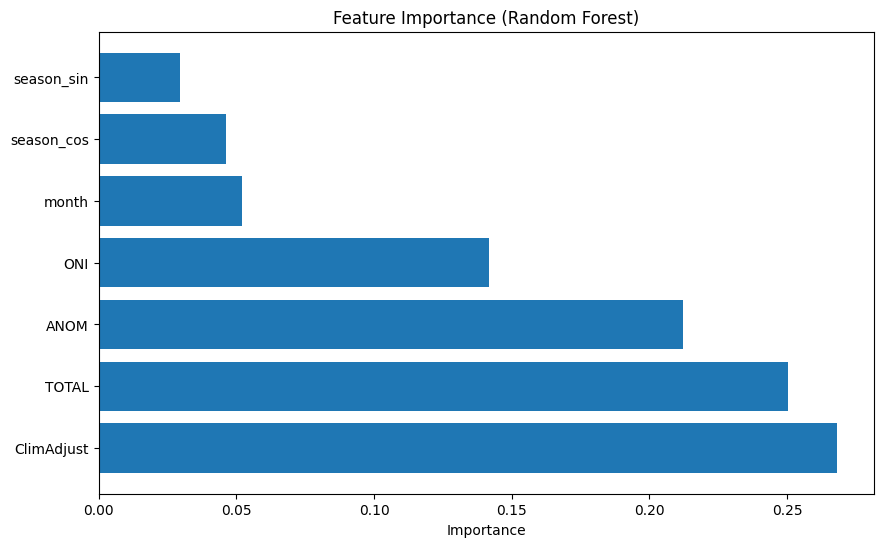

In [37]:
# Get the feature importances
importances = rf.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.show()